<font size='3'>
AE 543 Structural Dynamics
<br>
<font size="6">HW 05: Signal processing for vibration analysis</b></font>

The majority of the contants were developed by Professors Janko Slavič, and Domen Gorjup, University of Ljubljana, Laboratory for Dynamics of Machines and Structures (Ladisk)


Follow the video lectures 07 and 08 to complete this homework assignment. Complete all missing code blocks and instructions.
First, import the necessary packages.

In [57]:
import os                       # interface with the operating system, files etc. 
import numpy as np              # Python's standard numerical library
import matplotlib.pyplot as plt # Python's scientific visualization library
import lvm_read                 # read NI LabVeiw .lvm files

In [58]:
plt.rcParams.update({'font.size': 16}) # globally increase font size for plots
plt.style.use('seaborn-v0_8')          # use a prettier style for plots
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = 'gray'

Silence non-critical warnings:

In [59]:
import warnings
warnings.filterwarnings('ignore')

# Signal processing in Python basics
Measured signals are often contaminated with noise and require signal processing to reduce the effect of the noise, thus, revealing useful data. Read the acceleration data of a structure impacted with a modal hammer stored in NI Labview file called 1.lvm. 

In [60]:
file_path = 'data/acceleration/'
filename = os.path.join(file_path, '1.lvm')

lvm_data = lvm_read.read(filename)

lvm_data.keys()

dict_keys(['Decimal_Separator', 'Writer_Version', 'Reader_Version', 'Separator', 'Multi_Headings', 'X_Columns', 'Time_Pref', 'Operator', 'Date', 'Time', 0, 1, 2, 3, 'Segments'])

There are four segments in this file. Each segment represents a single measurement.

In [61]:
lvm_data['Segments']

4

Each segment contains various measurement data. Examin what the first segment contains:


In [62]:
lvm_data[0].keys()

dict_keys(['Channels', 'Samples', 'Date', 'Time', 'Y_Unit_Label', 'X_Dimension', 'X0', 'Delta_X', 'data', 'Channel names'])

In [63]:
lvm_data[0]['Channel names']

['X_Value',
 'Force (Trigger)',
 'Acceleration (Trigger)',
 'Voltage (Trigger)',
 'Comment']

Verify the shape of the data in all segments:

In [64]:
for segment in range(lvm_data['Segments']):
    print(lvm_data[segment]['data'].shape)

(25620, 4)
(25620, 4)
(25620, 4)
(25620, 4)


Merge the data from all segments and create a new array:

In [65]:
data = np.array([lvm_data[i]['data'] for i in range(lvm_data['Segments'])])

In [66]:
data.shape

(4, 25620, 4)

Declare and save variables to their relavent data:

In [67]:
n = data.shape[1]                # number of samples
dt = lvm_data[0]['Delta_X'][0]   # time step
sampling_frequency = 1/dt

time = np.arange(n)*dt           # time vector
force = data[:, :, 1]            # force vector
acceleration = data[:, :, 2]     # acceleration vector

And plt the time series:

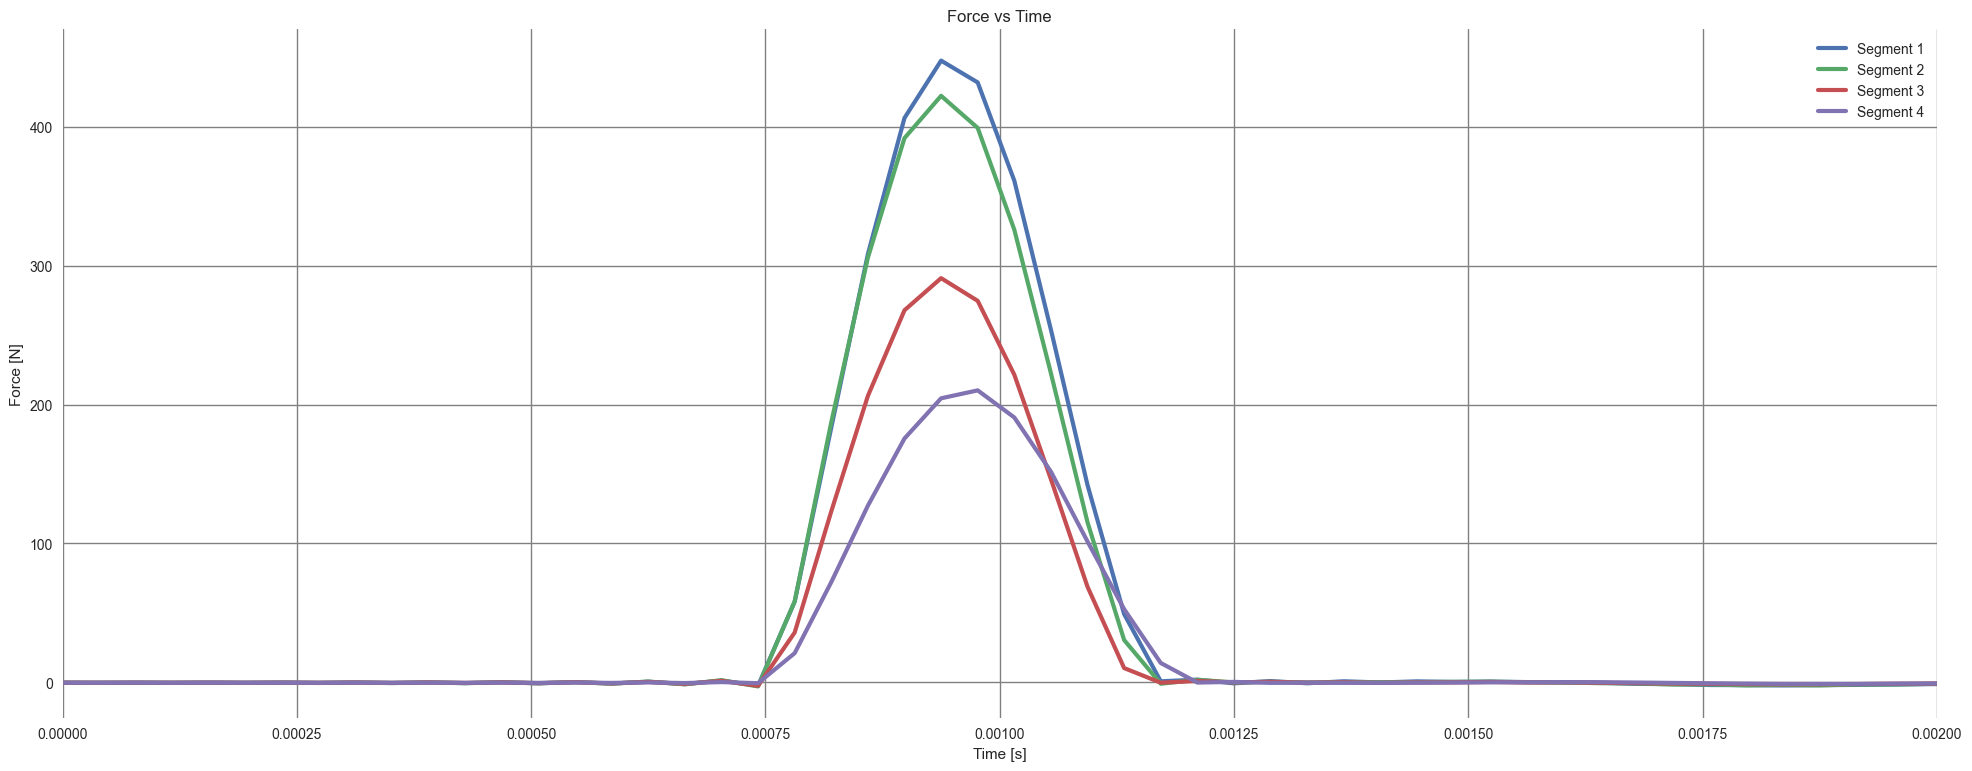

In [68]:
plt.figure(figsize=(20, 8))
for i in range(force.shape[0]):
    plt.plot(time, force[i], label=f'Segment {i+1}', linewidth=3)
plt.xlabel(r'Time [s]')
plt.ylabel(r'Force [N]')
plt.title(r'Force vs Time')
plt.xlim(0, 0.002)
plt.legend()
plt.grid(True)
plt.tight_layout()

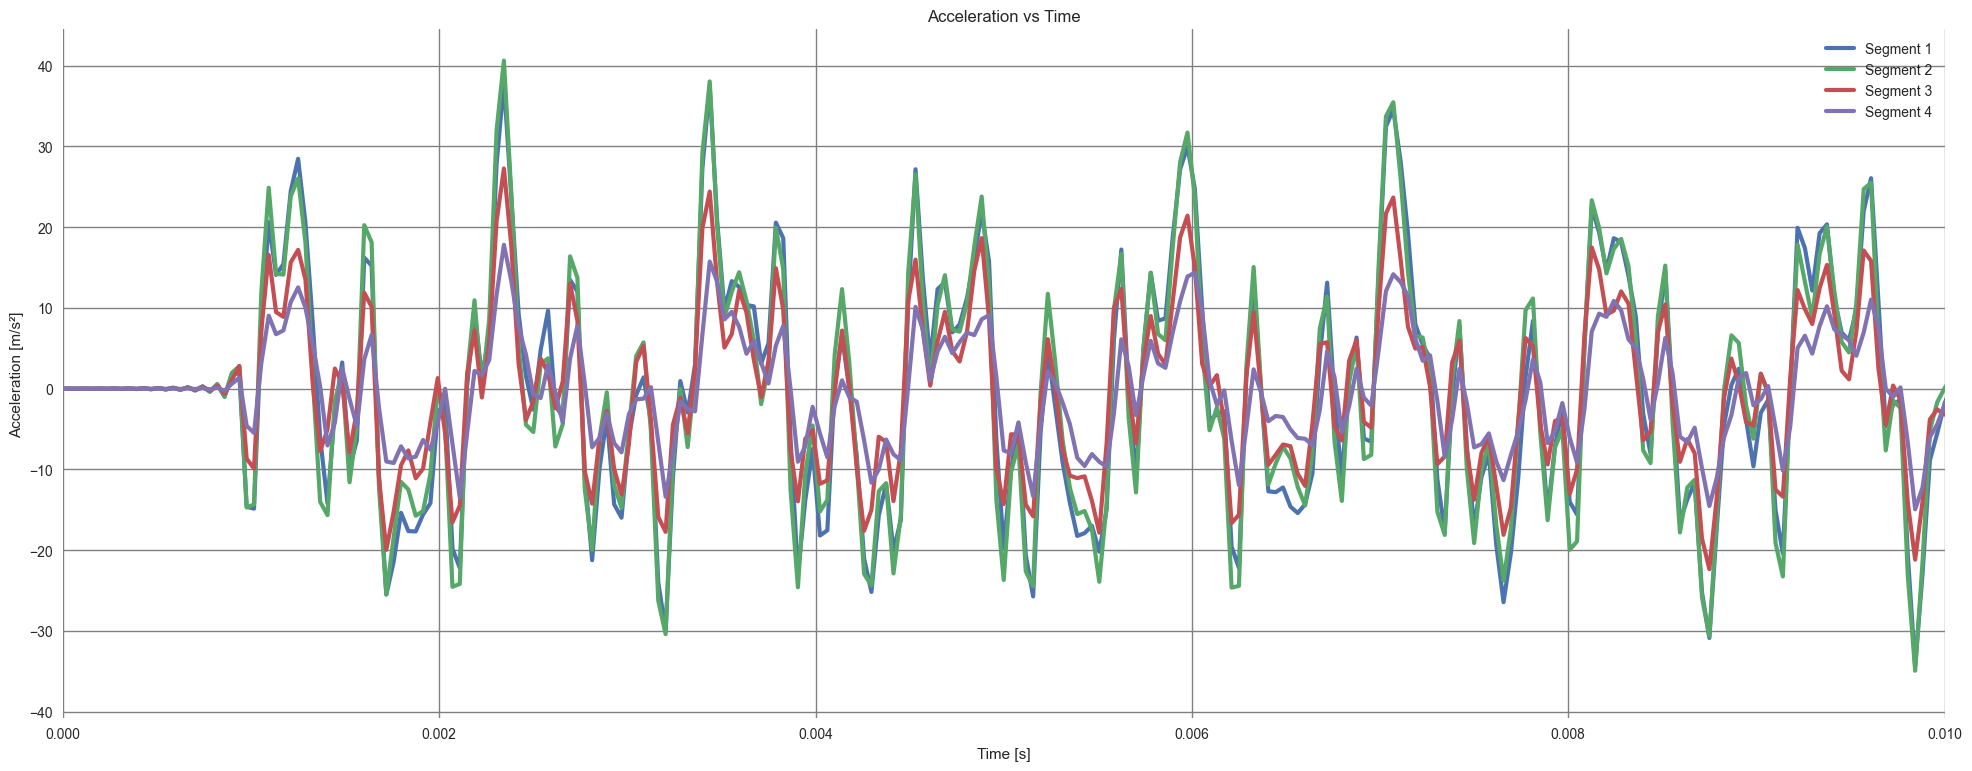

In [69]:
plt.figure(figsize=(20, 8))
for i in range(acceleration.shape[0]):
    plt.plot(time, acceleration[i], label=f'Segment {i+1}',linewidth=3)
plt.xlabel('Time [s]')
plt.ylabel(r'Acceleration [m/s²]')
plt.title(r'Acceleration vs Time')
plt.xlim(0, 0.01)
plt.legend()
plt.grid(True)
plt.tight_layout()

Perform singnal analysis on this data to extract as much useful information as possible.

## Fast Fourier Transform
The Fast Fourier Transform (FFT) is an optimized implementation of **Discrete Fourier Transform**:
$$
X_k = \sum_{m=0}^{n-1}\,a_m\,\exp\left(-2\,\pi\,\mathrm{i}\,\frac{m\,k}{n}\right)
$$

Since all input data are real, use the `np.fft.rfft` function, which expects real inputs and outputs only the positive frequency spectra.

In order to obtain the correct amplitudes, $X_k$, the outputs must be appropriately scaled.

In [70]:
Acceleration = np.fft.rfft(acceleration, n=n, axis=1) / n
Force = np.fft.rfft(force, n=n, axis=1) / n

# As we have effectively discarded the negative frequency spectra, the positive frequency components are doubled
Acceleration[1:] *= 2
Force[1:] *= 2


Next, compute the frequency vector:

In [71]:
freq = np.fft.rfftfreq(n, d=dt)

To view the data in a more meaningful way, we will use a logarithmic scale on y-axis (`semilogy`):

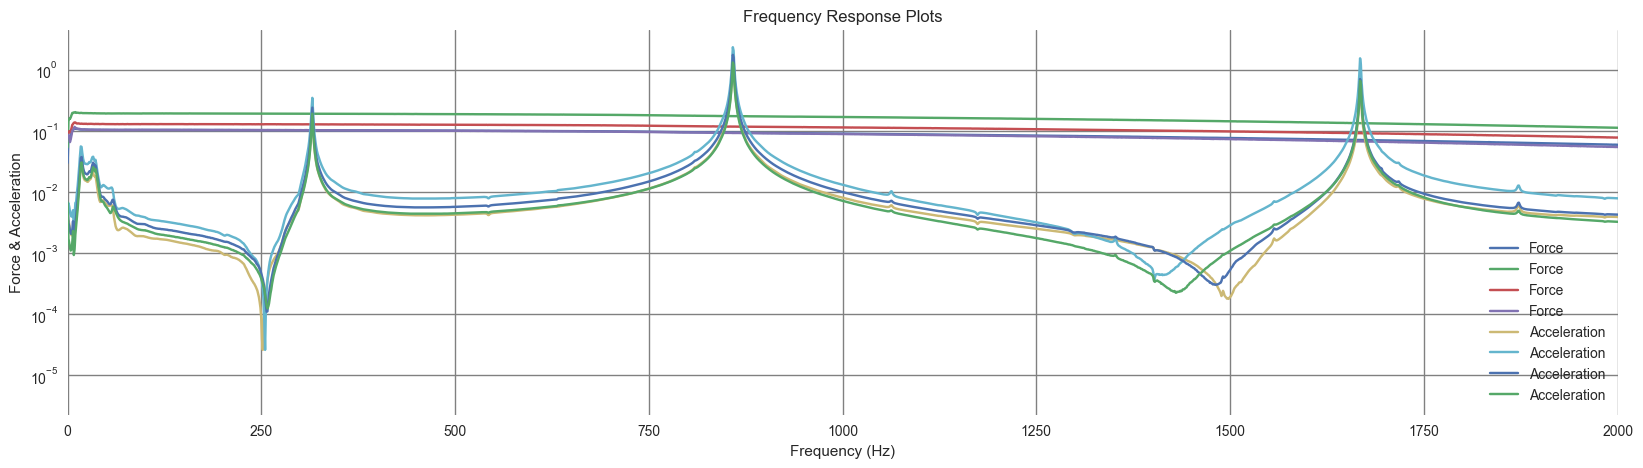

In [72]:
plt.figure(figsize=(20, 5))
plt.semilogy(freq, np.abs(Force).T, label = 'Force')
plt.semilogy(freq, np.abs(Acceleration).T, label = 'Acceleration')
plt.xlim(0,2000)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Force & Acceleration')
plt.title('Frequency Response Plots')
plt.legend()
plt.show()

## Windows
Windowing is commonly used on measured signals, often as a way to reduce spectral leakage when looking at the frequency content of a finite signal using the FFT, to reduce the effects of discontinuities at the edges of the signal segment as well as to reduce the noise in the signal.


Different windows are used for different types of the signals:
* Force impact - *force window*,
* Impact response - *exponential window*,
* Response to continuous excitation - *Hann, Hamming, Bartlett,...*.

Let's prepare a synthetic example of different window types, commonly used in modal analysis:

In [73]:
n = 500
time_windows = np.linspace(0, 1, n)

# Force window
force_w = np.zeros(n) # zero everywhere
force_w[:n//20] = 1   # keep the first 5% by setting window to 1

In [75]:
# Exponential window
exponential_w = np.exp(np.log(0.01)*time_windows)

In [77]:
# Other windows
hann = np.hanning(n)
hamming = np.hamming(n)
bartlett = np.bartlett(n)

Compute the FFT of each window to understand the characteristics of these windows in the frequency domain.

In [78]:
Force_window = np.fft.rfft(force_w)
Exponential_window = np.fft.rfft(exponential_w)
Hann_window = np.fft.rfft(hann)
Hamming_window = np.fft.rfft(hamming)
Bartlett_window = np.fft.rfft(bartlett) 
freq_windows = np.fft.rfftfreq(n, time_windows[1] - time_windows[0])

And plot the results:

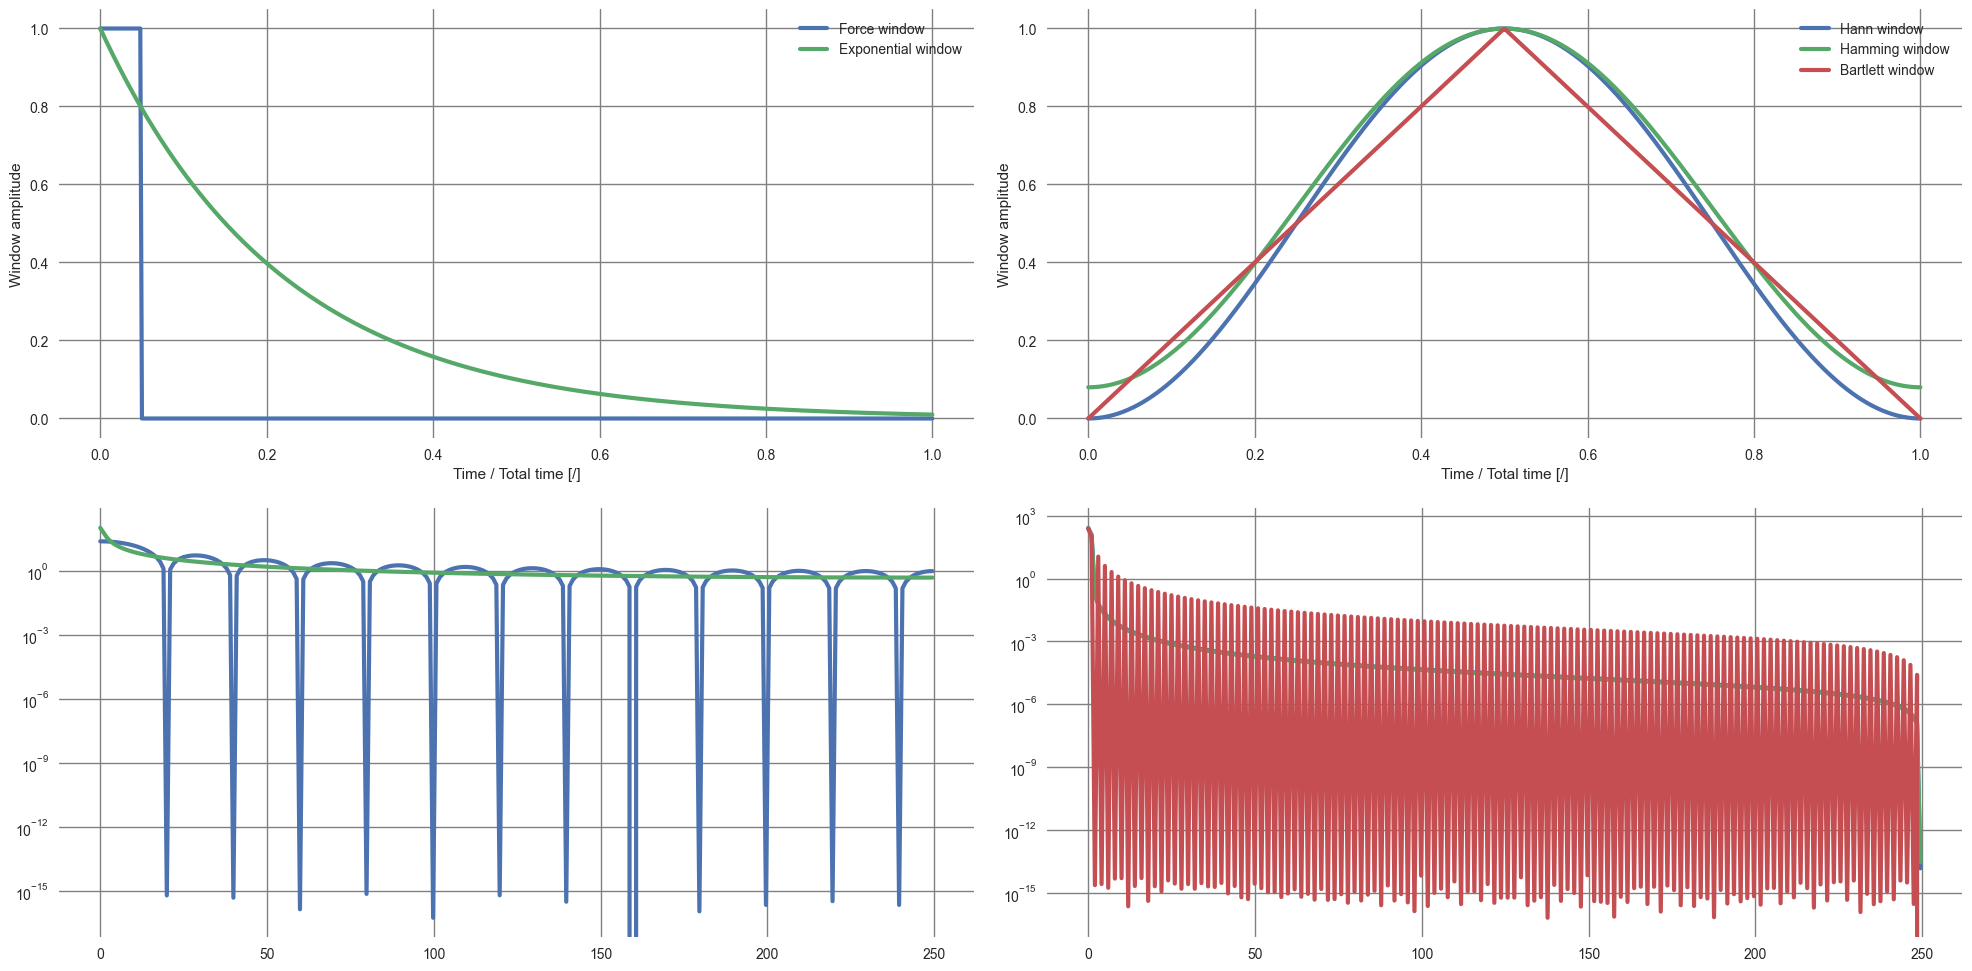

In [81]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

# Time domain plots
ax[0, 0].plot(time_windows, force_w, label='Force window', linewidth=3)
ax[0, 0].plot(time_windows, exponential_w, label='Exponential window', linewidth=3)
ax[0, 1].plot(time_windows, hann, label='Hann window', linewidth=3)
ax[0, 1].plot(time_windows, hamming, label='Hamming window', linewidth=3)
ax[0, 1].plot(time_windows, bartlett, label='Bartlett window', linewidth=3) 




ax[0, 0].legend()
ax[0, 1].legend()
ax[0, 0].grid(True)
ax[0, 1].grid(True)

ax[0, 0].set_xlabel('Time / Total time [/]')
ax[0, 0].set_ylabel('Window amplitude')
ax[0, 1].set_xlabel('Time / Total time [/]')
ax[0, 1].set_ylabel('Window amplitude')

# Frequency domain plots
ax[1, 0].semilogy(freq_windows, np.abs(Force_window), label='Force window', linewidth=3)
ax[1, 0].semilogy(freq_windows, np.abs(Exponential_window), label='Exponential window', linewidth=3)
ax[1, 1].semilogy(freq_windows, np.abs(Hann_window), label='Hann window', linewidth=3)
ax[1, 1].semilogy(freq_windows, np.abs(Hamming_window), label='Hamming window', linewidth=3)
ax[1, 1].semilogy(freq_windows, np.abs(Bartlett_window), label='Bartlett window', linewidth=3)      



plt.tight_layout()

## Welch’s method

The Welch's method is a technique for estimating the power spectral density (PSD) of a signal. It is an improvement over the basic periodogram method, which can produce noisy estimates of the PSD. Welch's method works by dividing the signal into overlapping segments, computing the periodogram for each segment using windowing, and then averaging these periodograms to produce a smoother estimate of the PSD.

It is implemented in `scipy` library in [`scipy.signal.welch()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html) and  [`scipy.signal.csd()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.csd.html).

The basic idea of the method:
* The time signal is divided into `nperseg`-length segments that overlap by `noverlap` points,
* Each of the segments is windowed,
* The power spectra (or PSD) of each windowed segment are computed,
* The results of all segments are averaged.

Overlapping of the segments preserve the information from the signal that is otherwise lost due to low influence at the segment edges (caused by most windows).

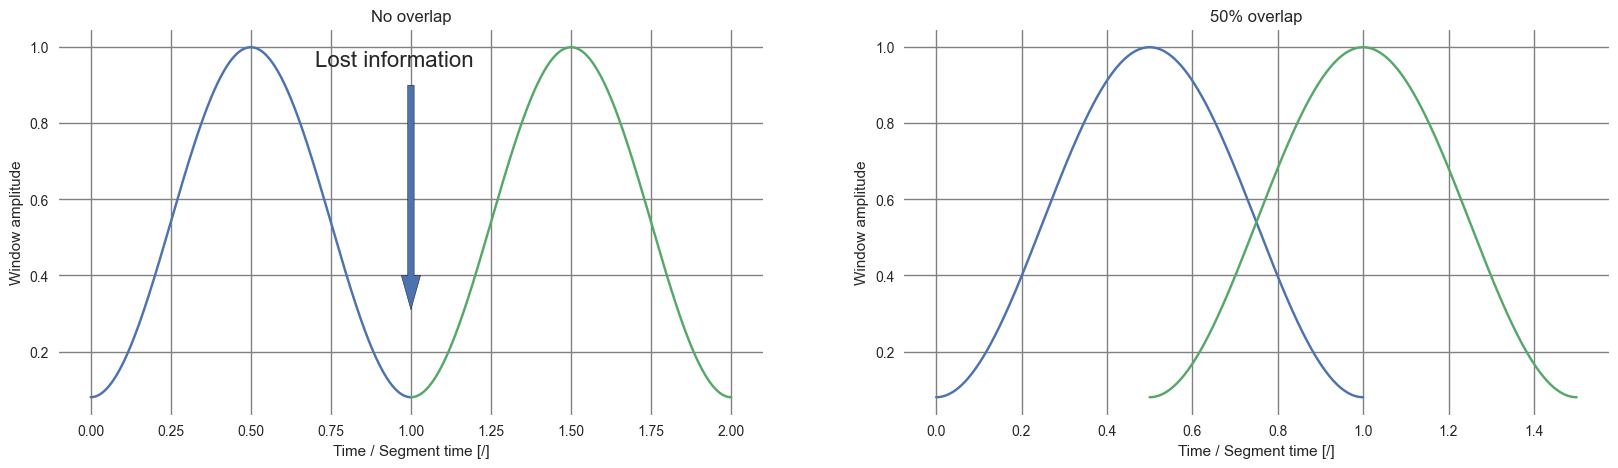

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))



Let's use the Welch's method to compute the PSD of our signals:

In [ ]:
from scipy.signal import welch, csd

In [ ]:
freq_PSD, force_PSD = welch(force, fs=sampling_frequency, nperseg=int(sampling_frequency//2), axis=1, scaling='density') # the PSD, computed along the second (time) axis
freq_PSD, acceleration_PSD = welch(acceleration, fs=sampling_frequency, nperseg=int(sampling_frequency//2), axis=1, scaling='density')

And plot the results:

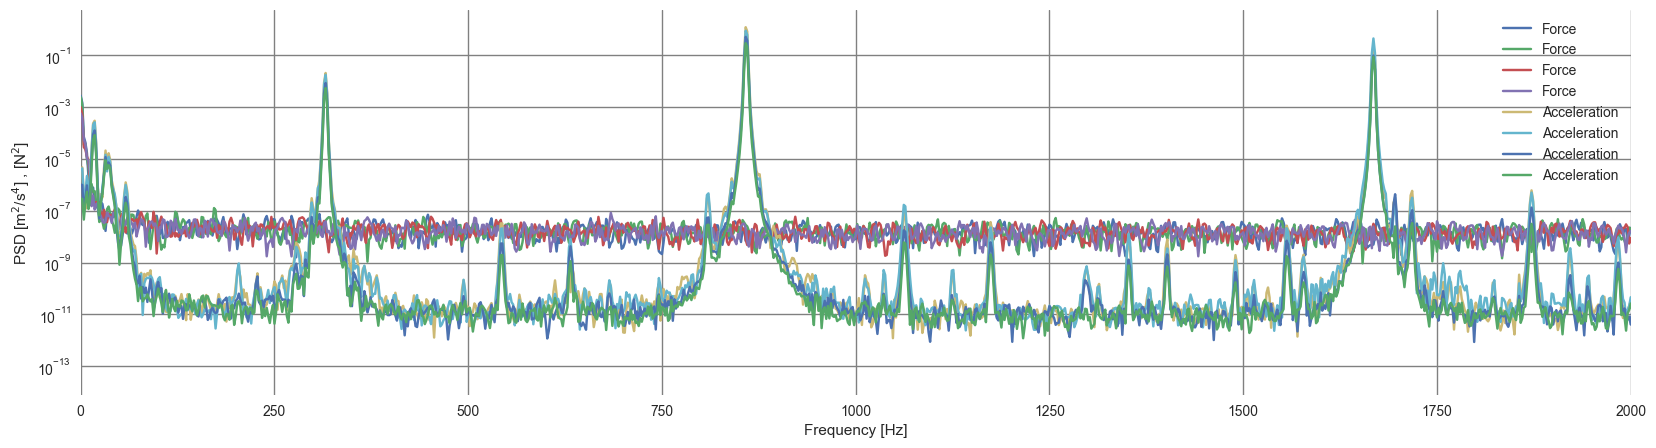

In [ ]:
plt.figure(figsize=(20, 5))
plt.semilogy(freq_PSD, force_PSD.T, label='Force')
plt.semilogy(freq_PSD, acceleration_PSD.T, label='Acceleration')
plt.xlim(0, 2000)
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [m$^2$/s$^4$] , [N$^2$]')
plt.legend()

## Convolution

The convolution integral is defined as:

$$(f*g)(t)=\int_{-\infty}^{\infty}f(\tau)\,g(t-\tau)\,\mathrm{d}\tau$$

(Discrete) convolution is implemented in `numpy` as `numpy.convolve()`.

Apply the convolution integral to calculate the response of a simulated system to an impulse force.
The impulse response function can be expressed as follows: 

$$ IRF=A_o e^{-\omega_n t} \sin{\omega_d t} $$

In [ ]:
t = np.linspace(0, 1, 1000)
irf = np.exp(-5*t) * np.sin(2*np.pi*5*t) # simulated impulse response function

impulse = np.zeros_like(t)
impulse[300] = 1.

Text(0, 0.5, 'Signal amplitude')

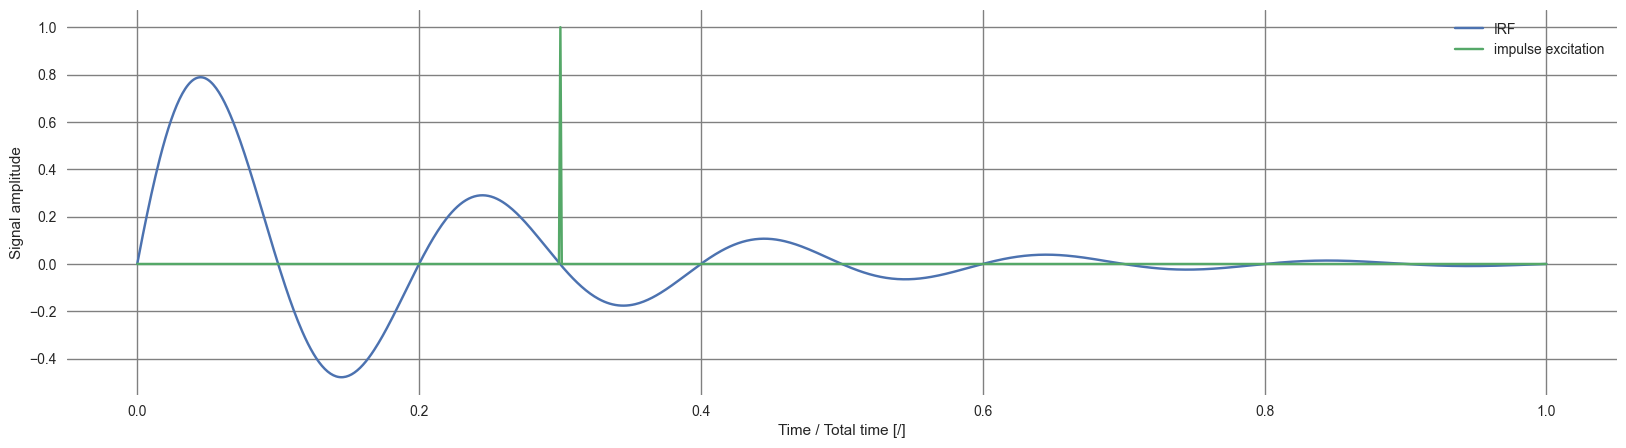

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(t, irf, label='IRF')
plt.plot(t, impulse, label='impulse excitation')

plt.legend()
plt.xlabel('Time / Total time [/]')
plt.ylabel('Signal amplitude')

Using convolution to compute a systems response to an excitation signal:

In [ ]:
response = np.convolve(impulse, irf, mode='full')[:len(t)]

Text(0, 0.5, 'Signal amplitude')

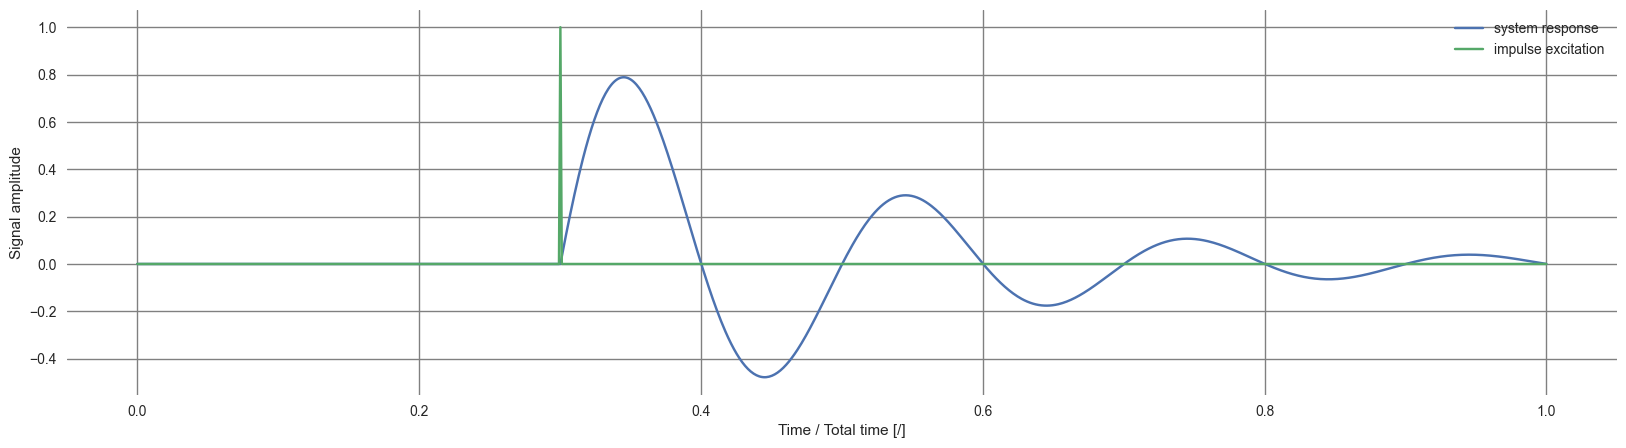

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(t, response, label='system response')
plt.plot(t, impulse, label='impulse excitation')

plt.legend()
plt.xlabel('Time / Total time [/]')
plt.ylabel('Signal amplitude')

# Experimental modal analysis basics

## The Frequency Response Function

The equation of motion of a **single degree of freedom system** is:

$$m\,\ddot x + c\,\dot x + k\,x = F_0\,e^{\mathrm{i}\,\omega\,t}$$

Where the stationary response is:

$$x(t) = \bar X\,e^{\mathrm{i}\,\omega\,t}$$

The equation of motion can be rewritten:

$$(-\omega^2\,m+\mathrm{i}\,c\,\omega+k)\,\bar X = F_0$$

or

$$\bar X = \frac{F_0}{(k-\omega^2\,m)+\mathrm{i}(c\omega)}$$

The complex ratio between response and excitation is the Receptance Frequency Response Function:

$$H(i\omega)=\frac{\bar X}{F_0}=\frac{1}{(k-\omega^2\,m)+\mathrm{i}(c\omega)}$$

**Complete the following:**

1. Build a synthetic Frequency Response Function of a single degree of freedom system.
2. Plot the absolute value of the FRF
3. Plot the phase of the FRF

Notes figures with no labels will recieve no credits. 

In [ ]:
k = 21000
m = 0.3
d = 0.001
omega = np.linspace(0, 500, 1000)

### Experimental FRF computation

After computing FFTs for the measurements, we can estimate the Frequency Response Functions (FRF).

The FFTs of response and excitation:
$$X(f)=FFT(x(t))$$

$$F(f)=FFT(f(t))$$

Auto-spectra and cross-spectra are computed:
$$S_{ff}(f) = \frac{1}{T} ~ F^*(f) \, F(f)$$

$$S_{xf}(f) = \frac{1}{T} ~ X^*(f) \, F(f)$$
These can be **averaged** in order to reduce the noise.

Depending on our assumptions about the noise in our measurement chain, differnt optimal FRF estimators can be computed:

* $H_1$ assumes a noisy *reponse* measurement:
$$H_1(f) = \frac{S_{fx}(f)}{S_{ff}(f)}$$

* $H_2$ assumes a noisy *excitation (force)* measurement:
$$H_2(f) = \frac{S_{xx}(f)}{S_{xf}(f)}=\frac{X^*(f)X(f)}{X^*(f)F(f)}$$

Coherence is a measure of the systems linearity, which can be used to assess the measurement quality:

$$\gamma^2 = \frac{H_1(f)}{H_2(f)}$$

(Ideally, coherence values should be as close to 1 as possible.)

**Compelte the following**:

1. Compute the cross and auto spectra using averaging
2. Compute the $H_1$ and $H_2$ FRF estimators
3. Compute the coherence
4. Plot the obtained FRF estimators
5. Plot the coherence as a function of frequency

In [ ]:
N_samples = acceleration.shape[1]  # number of samples in each segment

# Compute the auto and cross-spectra
freq, S_xx = 
freq, S_ff = 
freq, S_xf = 
freq, S_fx = 

# Average the spectra over all segments
S_xx = 


# Compute the transfer function estimators
H_1 = 
H_2 = 

# Compute the coherence
coherence = 

Text(0.5, 0, 'Frequency [Hz]')

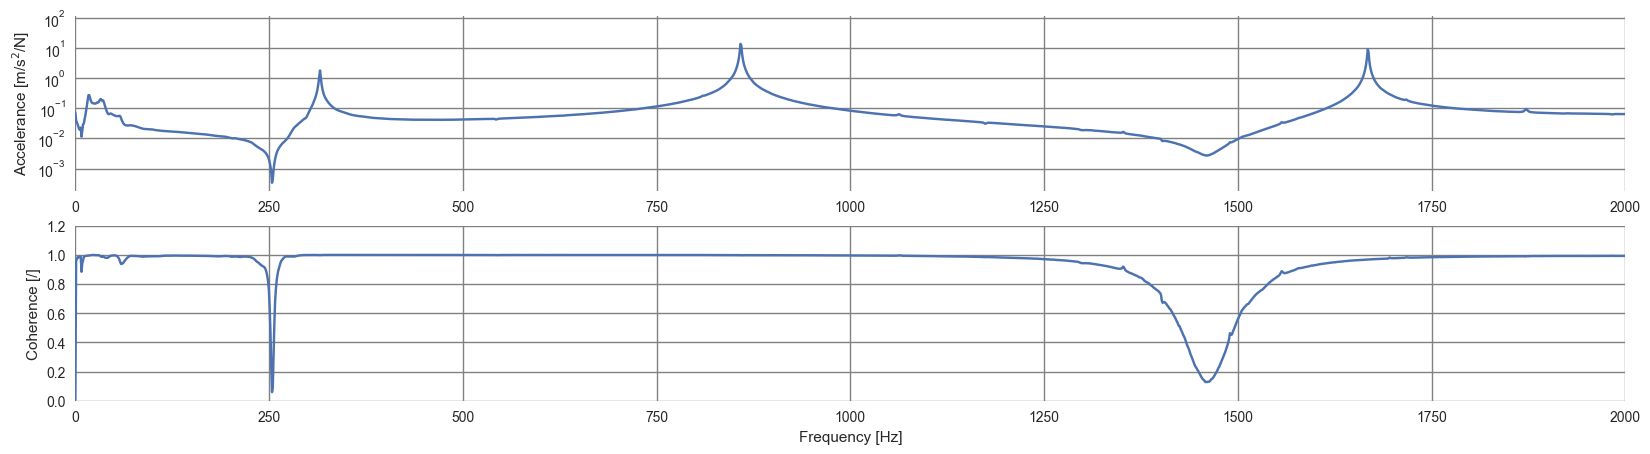

In [ ]:
fig, ax = plt.subplots(2, figsize=(20, 5))



### Computing FRFs using the sdypy-FRF package

In [ ]:
from sdypy import FRF

First, we make an instance of the `FRF` class, setting all the essential parameters:

In [ ]:
frf = FRF.FRF(
    sampling_freq=int(sampling_frequency),
    fft_len=force.shape[1], 
    exc_type='f', 
    resp_type='a',
    window=['force:0.01', 'exponential:0.01']
    )

Now we can add data. Each segment that is added is averaged with the previously added segments.

In [ ]:
for i in range(force.shape[0]):
    frf.add_data()

Obtaining the FRF and frequency vector is now easy:

In [ ]:
receptance = 
frequency = 

Sdypy-FRF supports MIMO systems, the output is a FRF matrix:

In [ ]:
receptance.shape

(1, 1, 12811)

Let's extracct our single FRF from the matrix:

In [ ]:
receptance = 

And plot the results:

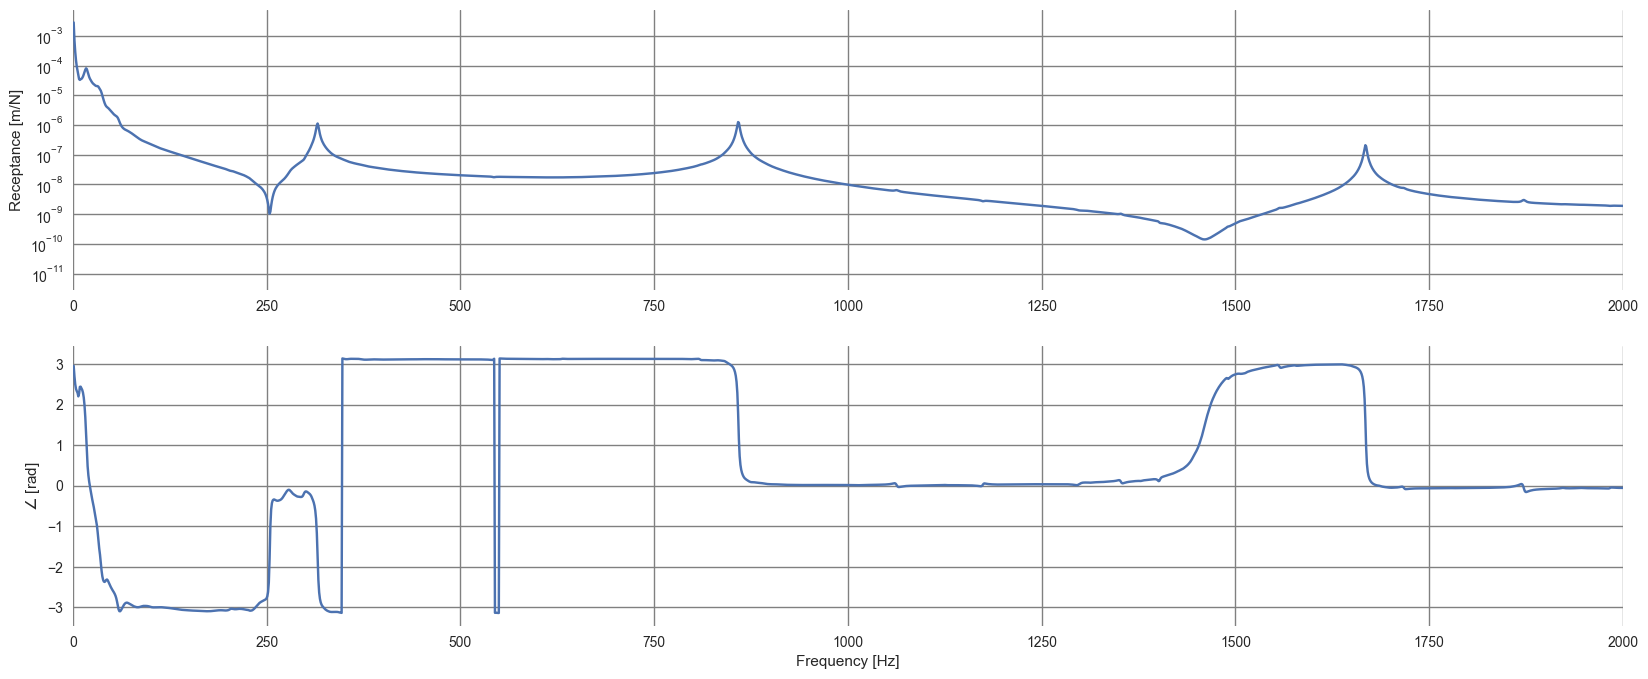

In [ ]:
fig, ax = plt.subplots(2, figsize=(20, 8))



Let's read all `.lvm` files and compute the FRFs:

In [ ]:
import glob # a convenient python module to find files, matching a finemane pattern

In [ ]:
files = glob.glob(os.path.join(file_path, '*.lvm'))

In [ ]:
FRF_mtx = []

# Iterating over all files
for file in files:
    _lvm_data = lvm_read.read(file)
    _data = np.array([_lvm_data[i]['data'] for i in range(_lvm_data['Segments'])])
    _force = _data[:, :, 1]  
    _acc = _data[:, :, 2]
    
    # Defining the FRF
    frf = FRF.FRF(
        exc=_force, # force data, shape (repeats, samples)
        resp=_acc,  # acceleration data, shape (repeats, samples)
        sampling_freq=int(sampling_frequency), 
        fft_len=_force.shape[1], 
        exc_type='f', 
        resp_type='a',
        window=['force:0.01', 'exponential:0.01']
        )
    
    # Extracting the FRF and frequency vector
    accelerance = frf.get_FRF(form='accelerance')[0, 0, :]
    frequency = frf.get_f_axis()
    FRF_mtx.append(accelerance)

FRF_mtx = np.asarray(FRF_mtx) # Convert list to ndarray


c:\Users\habto\AppData\Local\Programs\Python\Python312\Lib\site-packages\lvm_read.py:49: DeprecationWarning: numpy.core._multiarray_umath is deprecated and has been renamed to numpy._core._multiarray_umath. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core._multiarray_umath._reconstruct.
  lvm_data = pickle.load(f)
c:\Users\habto\AppData\Local\Programs\Python\Python312\Lib\site-packages\lvm_read.py:49: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in a

In [ ]:
FRF_mtx.shape, frequency.shape

((9, 12811), (12811,))

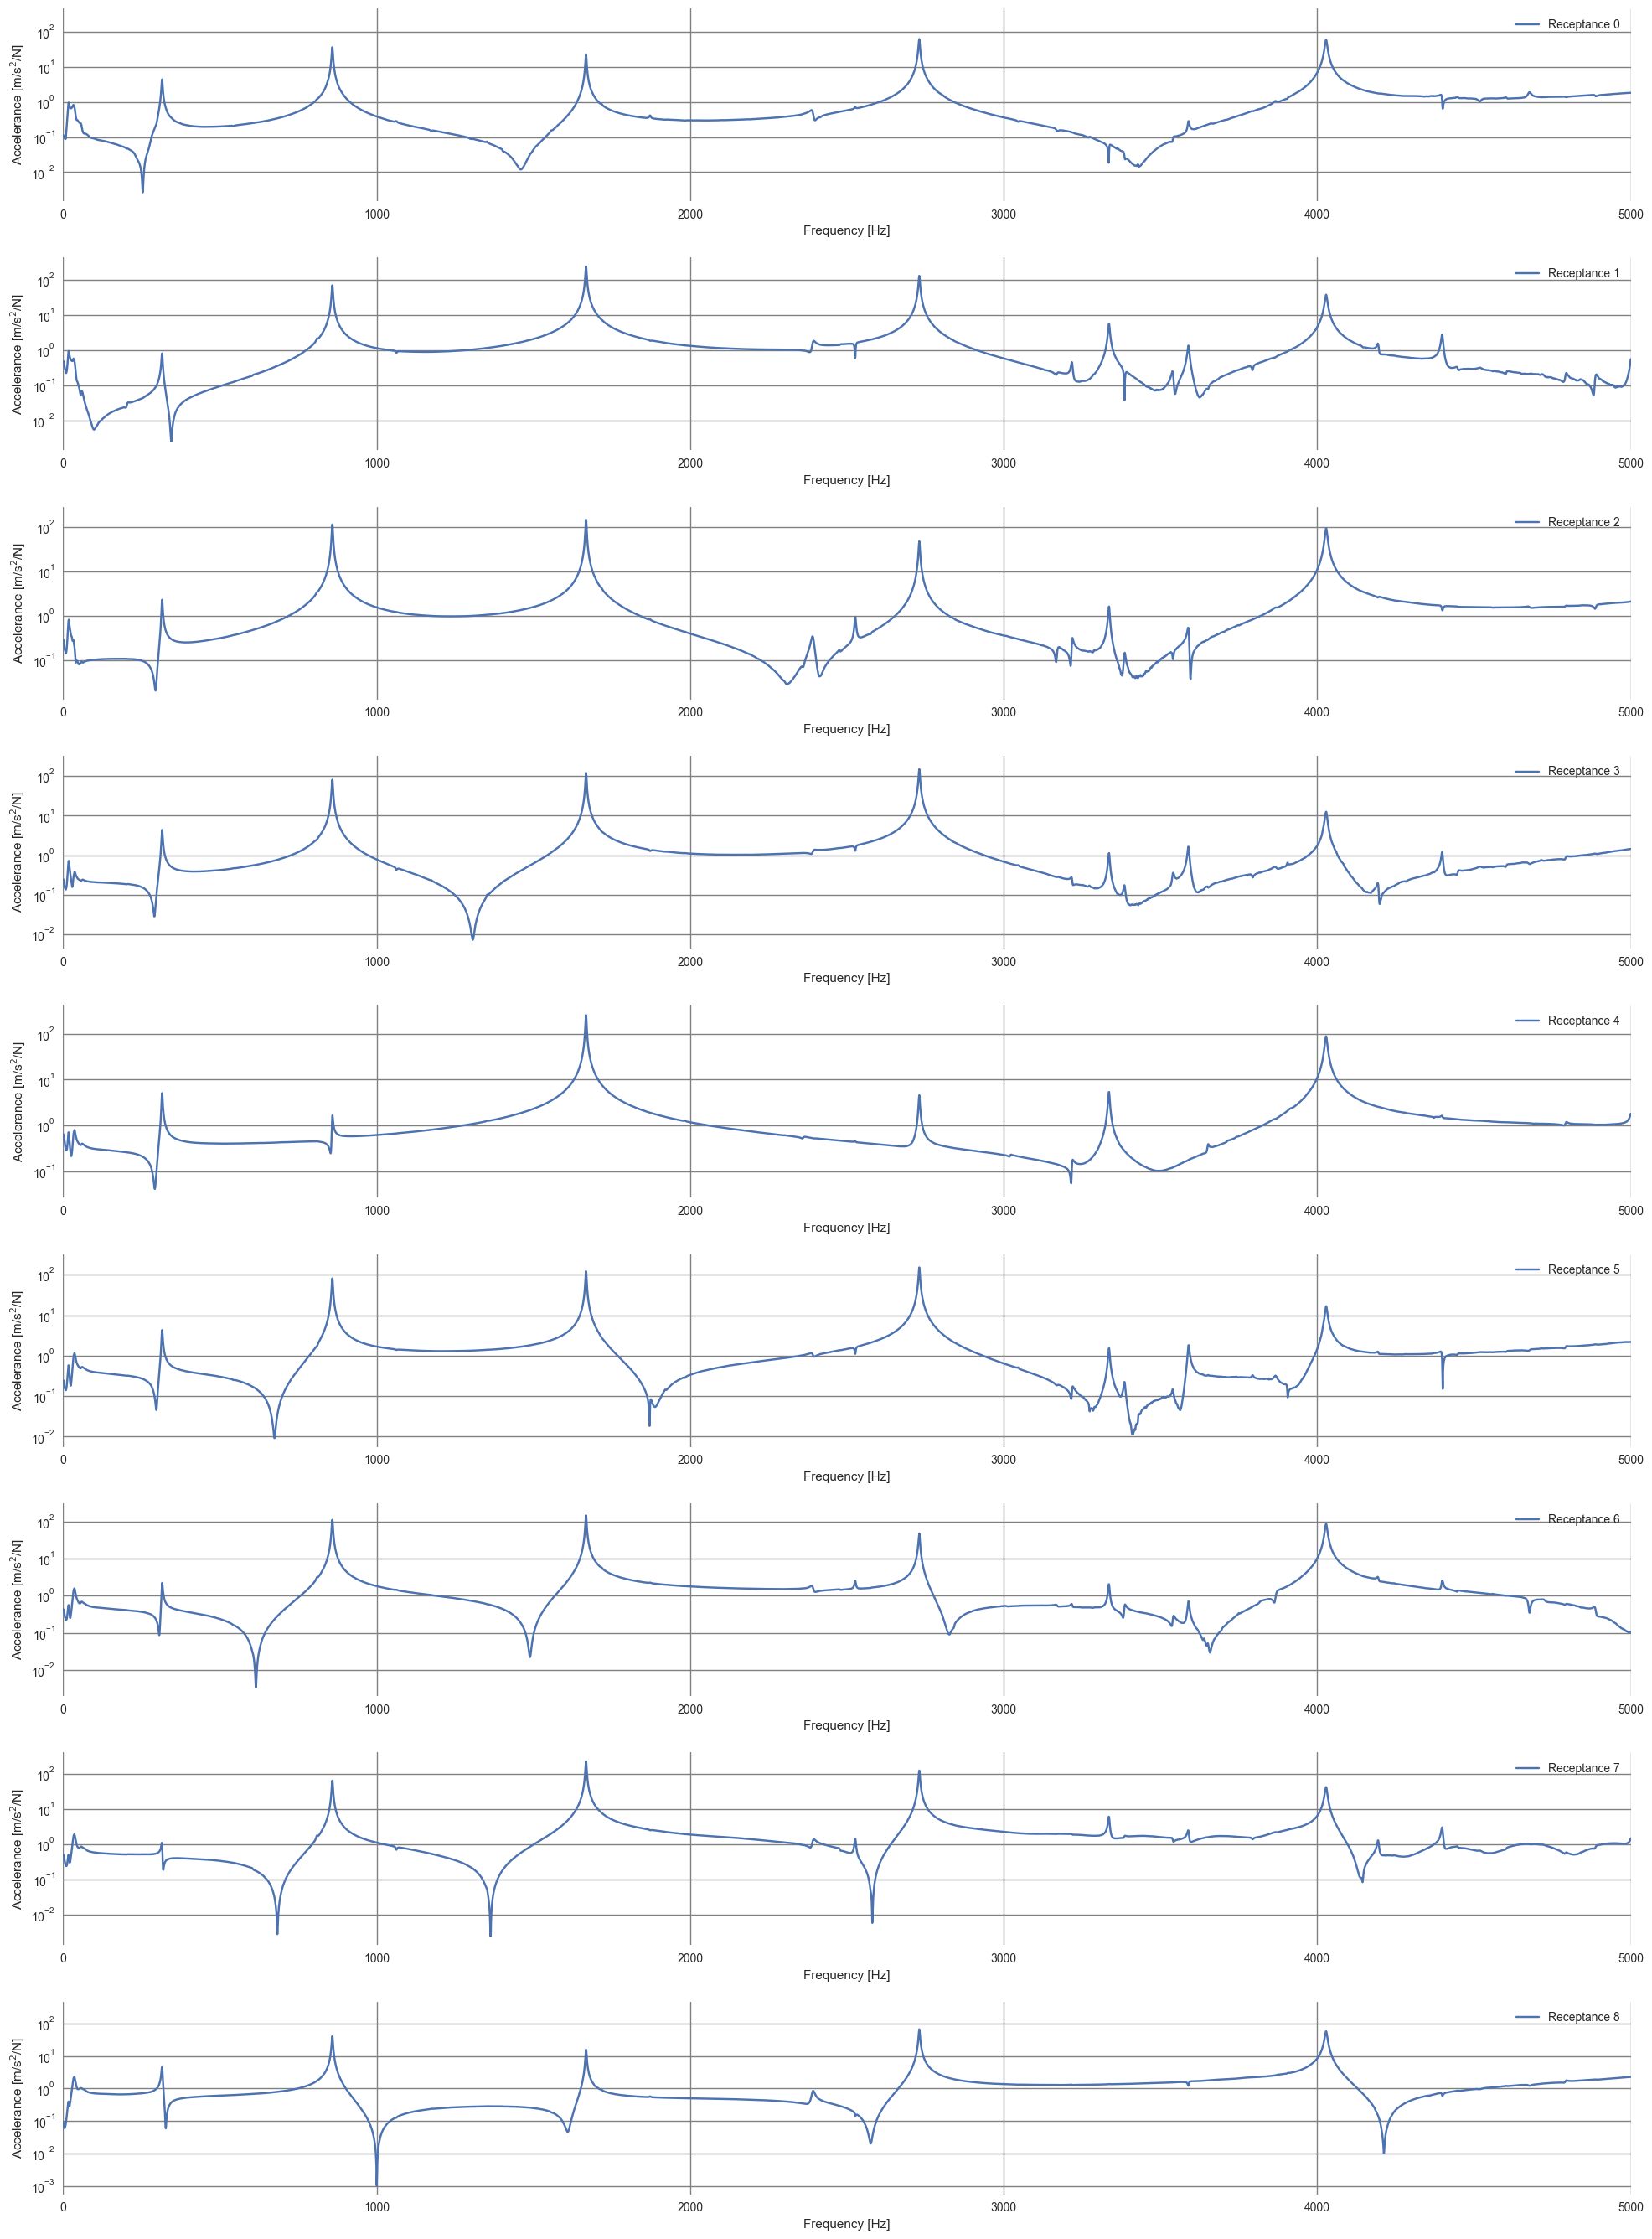

In [ ]:
fig, ax = plt.subplots(FRF_mtx.shape[0], figsize=(20, 3*FRF_mtx.shape[0]))

for i, FRF_i in enumerate(FRF_mtx):
    ax[i].semilogy(frequency, np.abs(FRF_i), label=f'Receptance {i}')
    ax[i].legend()
    ax[i].set_xlim(0, 5000)
    ax[i].set_xlabel('Frequency [Hz]')
    ax[i].set_ylabel('Accelerance [m/s$^2$/N]')
fig.tight_layout()

## FRF Curve fitting: LSCF

To identify modal parameters of the system, curve fitting methods are often used on the measured FRFs. The *Least-Squares Frequency Domain* (LSCF) method is one of the most often used.

A rational polynomial function can be used to approximate an FRF:

$$
\alpha_j(\omega)=\frac{\sum_r^{2N} a_{j,r}\cdot \mathrm{e}^{-\mathrm{i}\,r\,\Delta t\,\omega}}
{\sum_r^{2N} b_{r}\cdot \mathrm{e}^{-\mathrm{i}\,r\,\Delta t\,\omega}}
$$

Poles of the function represent the complex eigenvalues of the system:
$$
\lambda_r = -\zeta_r \,\omega_r\pm \mathrm{i}\,\omega_r\,\sqrt{1-\zeta_r^2}
$$

With increasing the polynomial order ($N$), the number of poles also increases. 

Using a high polynomial orde, many physically meaningless poles can potantially be introduced. The **stability chart** is used to manually select only those that are physically meaningful (represent actual system resonances).

**Stabilization chart example:**

![stab_chart.jpg](./figures/stab_chart.jpg)

## FRF reconstruction: LSFD 

Using the identified modal parameters (e. g. using LSCD), FRF functions can be reconstructed, for example to reconstruct amplitudes of the modal constants, providing information about the FRF's peak amplitudes and subsequently, mode shapes.

Using the *Least-Squares Frequency-Domain method* (LSFD), the FRF is modeled as a polynomial:

$$\alpha_j(\omega) = \sum_{r=1}^{N}\Big(\frac{_rA_j}{\mathrm{i}\,\omega - \lambda_r} + \frac{_rA_j^*}{\mathrm{i}\,\omega - \lambda_r^*}\Big)-\frac{A_L}{\omega^2} + A_U;$$

* $^*$ - complex conjugate
* $j$ - measured location
* $r$ - mode index
* $_rA_j$ - $r$-th modal constant at location $j$
* $A_L$ and $A_U$ - lower and upper residual
* $\lambda_r$ - $r$-th complex eigenvalue from LSCF

With all frequencies $\omega$ and all locations $j$, a system of equations is built.

Modal constants and residuals are computed by solving the overdetermined system of equations in a least-squares sense.

### Modal identification using the sdypy-EMA package


LSCF and LSFD are implemented in the [sdypy-EMA](https://github.com/sdypy/sdypy-EMA) package.

Let's see an example:

In [ ]:
from sdypy import EMA

In [ ]:
FRF_mtx = np.nan_to_num(FRF_mtx) # Remove potential NaN values (to avoid issues with zero-division etc.)
FRF_mtx.shape

(9, 12811)

Create a `Model` object, implementing the LSCF curve-fitting method. Play with the lower and upper frequency limits. 

In [ ]:
acc = EMA.Model(
    frf=FRF_mtx, 
    freq=frequency, 
    lower=10,
    upper=3000, 
    pol_order_high=60
    )

* `lower` - lowest frequency to observe
* `upper` - highest frequency to observe
* `pol_order_high` - highest polynomial order

Compute the poles of the rational polynomial function. 

In [ ]:
acc.get_poles(show_progress=True)

  0%|                                                                        | 0/60 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 151.23it/s]


and draw the stabilization chart to choose the stable poles:

In [ ]:
# acc.select_poles()

The poles can be chosen automatically, but use caution! It is a good idea to use your experimental data to approximate the resonance frequencies to help selecting the poles. 

In [ ]:
approx_nat_freq = [315, 860, 1670, 2730] # approximate natural frequencies (unsupervised)
acc.select_closest_poles(approx_nat_freq)

100%|██████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 223.09it/s]


Let's look at the identified natural frequencies: 

In [ ]:
acc.nat_freq

array([ 315.64303352,  858.72408076, 1668.64985702, 2730.76834465])

And the damping coefficients:

In [ ]:
acc.nat_xi

array([0.00482033, 0.001729  , 0.0010144 , 0.00063839])

Let's reconstrunct the FRF's compute the modal constants using the `lsfd` method:

In [ ]:
H, A = acc.get_constants(FRF_ind='all')

In [ ]:
A.shape

(9, 4)

In [ ]:
H.shape

(9, 3002)

Plot the absolute measured and reconstructed (modeled) FRFs in the same plot.  

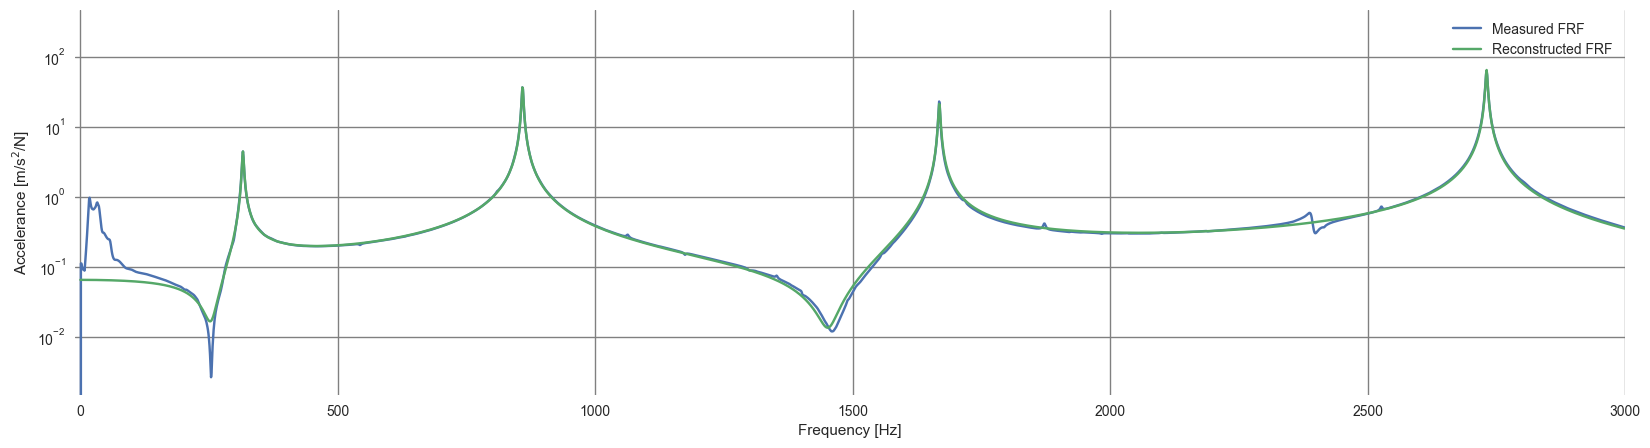

In [ ]:
plt.figure(figsize=(20, 5))
plt.semilogy()
plt.semilogy()
plt.xlim(-10, 3000)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Accelerance [m/s$^2$/N]')
plt.legend()

Let's plot the unit-norm normalized identified mode shapes:

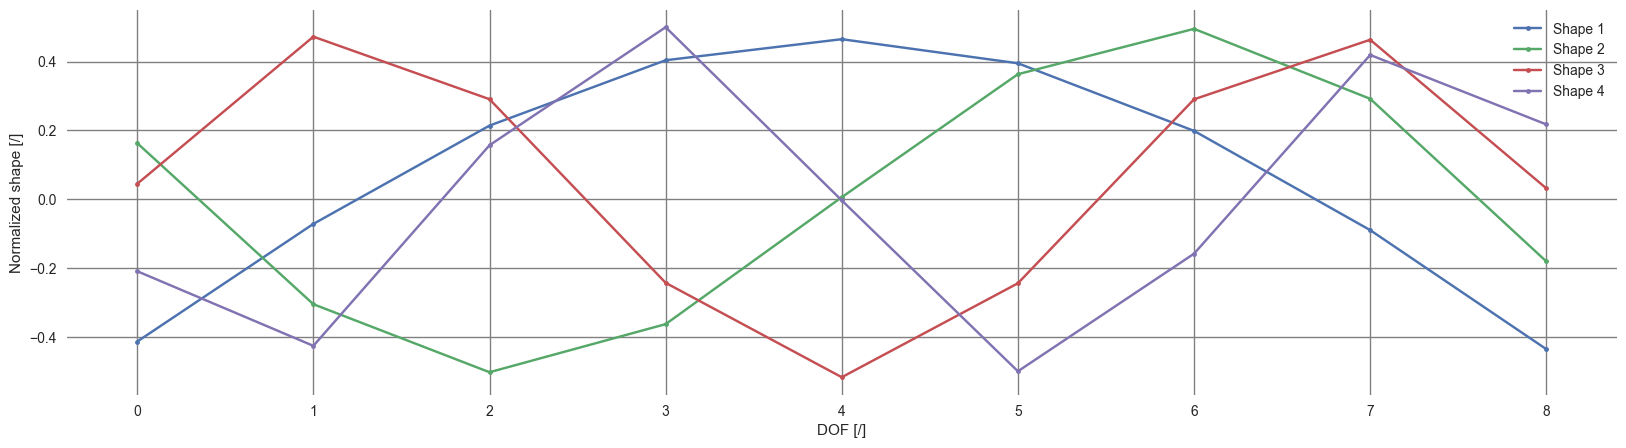

In [ ]:
plt.figure(figsize=(20, 5))
for i, shape in enumerate(A.T):
    plt.plot(np.imag(shape/np.linalg.norm(shape)), '.-', label=f'Shape {i+1}');
plt.xlabel('DOF [/]')
plt.ylabel('Normalized shape [/]')
plt.legend()